# Inferring rate parameters

In [4]:
library(R2jags)
library(ggplot2)

We will now consider some more examples in which we want to estimate rate parameters.

## Example 1: Bernoulli trials

We will start by flipping a coin:

In [33]:
true_theta <- 0.6

coin_flips <- rbinom(n = 100, size = 1, prob = true_theta)

head(y, 20)

 [1] 1 0 1 1 0 0 0 1 1 1 1 1 1 0 0 0 1 1 1 1

In [17]:
modelstr <- "
model{
  for (i in 1:length(y)) { 
    y[i] ~ dbern(theta)
    }
    theta ~ dbeta(1, 1)
}"

In [35]:
jagsdata <- list(y = coin_flips)

In [36]:
inits <- function() {
    list(theta = rbeta(1, 1, 1))
    }

In [37]:
parameters <- "theta"

In [38]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 102

Initializing model



In [39]:
fit

Inference for Bugs model at "5", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
theta      0.639   0.047   0.544   0.609   0.639   0.672   0.729 1.001  1900
deviance 131.664   1.391 130.685 130.776 131.117 131.976 135.344 1.001  1900

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 1.0 and DIC = 132.6
DIC is an estimate of expected predictive error (lower deviance is better).

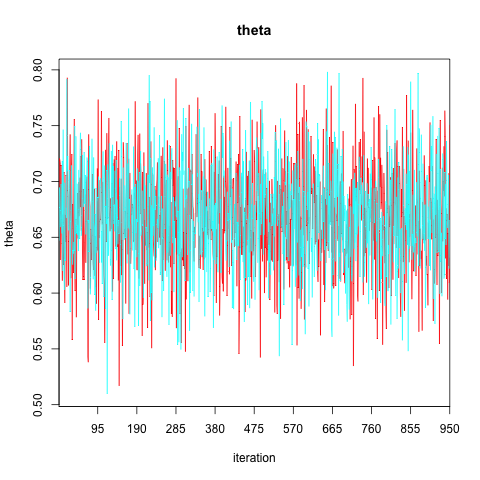

In [25]:
traceplot(fit, varname = "theta")

In [40]:
samples <- fit$BUGSoutput$sims.list
theta <- samples$theta
head(theta)

          [,1]
[1,] 0.6081687
[2,] 0.5826225
[3,] 0.5648738
[4,] 0.6042338
[5,] 0.6722936
[6,] 0.6467148

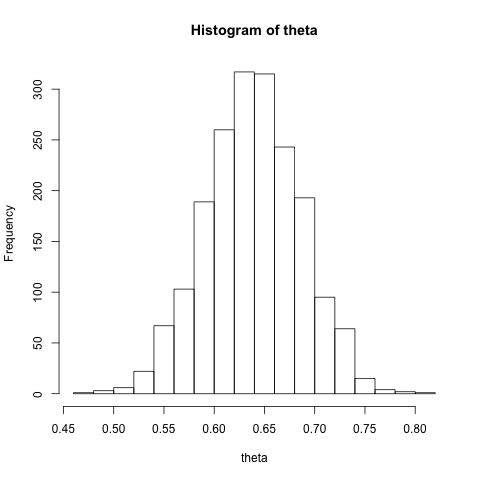

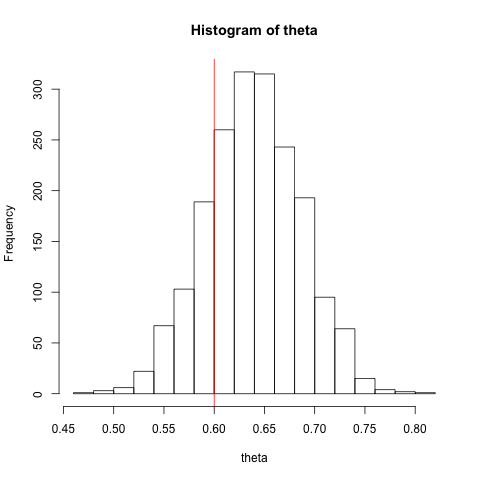

In [41]:
hist(theta)
abline(v = true_theta, col = "red")

## Example 2: estimating a common rate

Now, suppose we have 20 people answering questions in our test, and we would like to infer a common ability.

In [43]:
true_ability <- 0.75

n_questions <- 10

answers <- rbinom(n = 20, size = n_questions, prob = true_ability)

In [48]:
modelstr <- "
model{
  for (i in 1:n_obs) { 
    y[i] ~ dbinom(theta, n)
    }
    theta ~ dbeta(1, 1)
}"

In [49]:
jagsdata <- list(y = answers, n = n_questions, n_obs = length(answers))

In [50]:
inits <- function() {
    list(theta = rbeta(1, 1, 1))
    }

In [51]:
parameters <- "theta"

In [52]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 24

Initializing model



In [53]:
print(fit)

Inference for Bugs model at "7", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
         mu.vect sd.vect   2.5%    25%    50%    75%  97.5%  Rhat n.eff
theta      0.708   0.033  0.640  0.688  0.708  0.731  0.769 1.001  1500
deviance  67.622   1.510 66.562 66.668 67.022 67.974 71.937 1.001  1900

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 1.1 and DIC = 68.8
DIC is an estimate of expected predictive error (lower deviance is better).


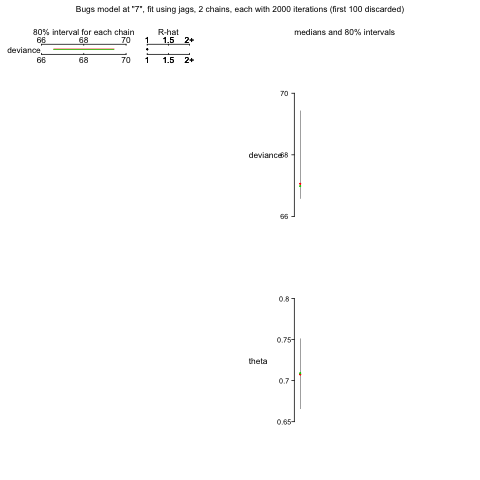

In [54]:
plot(fit)

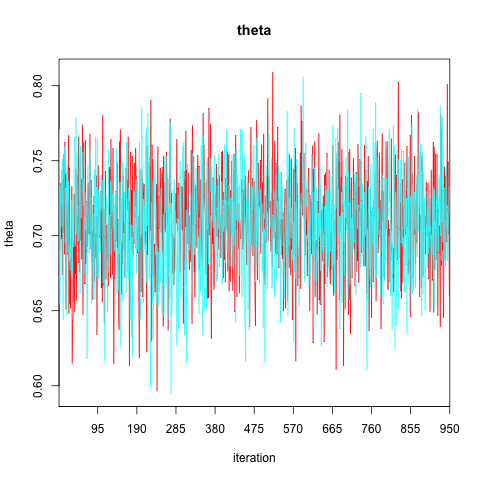

In [55]:
traceplot(fit, varname = "theta")

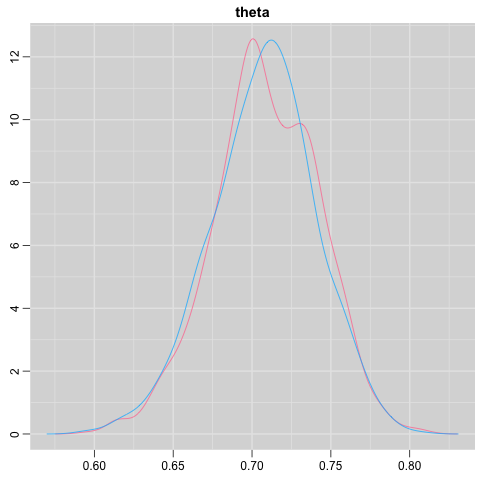

In [56]:
library(mcmcplots)
denplot(fit, parms = "theta")

## Example 3: comparing two rates

In this example, suppose we have 40 people from 2 groups answering questions in our test, and we would like to infer a common ability for each group, and we would like to know whether there is a difference between the groups.

In [58]:
group1_ability <- 0.8
group2_ability <- 0.5

n_questions <- 10

group1_answers <- rbinom(n = 20, size = n_questions, prob = group1_ability)
group2_answers <- rbinom(n = 20, size = n_questions, prob = group2_ability)

In [63]:
library(ggplot2)
library(tidyr)
library(dplyr)

In [70]:
df <- data.frame(group1 = group1_answers, group2 = group2_answers)
df <- df %>% gather(group, answers, one_of(c("group1", "group2")))
df %>% head(10)

    group answers
1  group1       8
2  group1       7
3  group1      10
4  group1       8
5  group1       5
6  group1       7
7  group1       9
8  group1       8
9  group1       9
10 group1       7

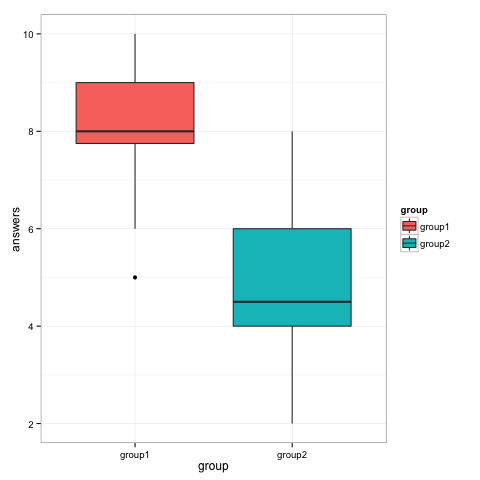

In [69]:
p <- ggplot(df, aes(x = group, y = answers, fill = group)) + theme_bw()
p + geom_boxplot()

In [79]:
modelstr <- "
model{
  for (i in 1:n_obs) { 

    # nested indexing
    y[i] ~ dbinom(theta[group[i]], n)
    }
  for (j in 1:n_groups) {
    theta[j] ~ dbeta(1, 1)
    }
    
  delta <- theta[1] - theta[2]
}"

In [76]:
df$group_idx <- match(df$group, unique(df$group))
df %>% head()
df %>% tail()

   group answers group_idx
1 group1       8         1
2 group1       7         1
3 group1      10         1
4 group1       8         1
5 group1       5         1
6 group1       7         1

    group answers group_idx
35 group2       2         2
36 group2       4         2
37 group2       6         2
38 group2       4         2
39 group2       6         2
40 group2       4         2

In [78]:
jagsdata <- list(y = df$answers, 
                 n = n_questions, 
                 n_obs = length(df$answers),
                 group = df$group_idx,
                 n_groups = length(unique(df$group)))

In [80]:
inits <- function() {
    list(theta = rbeta(jagsdata$n_groups, 1, 1))
    }

In [85]:
parameters <- c("theta", "delta")

In [86]:
fit <- jags(data = jagsdata, model.file = textConnection(modelstr), 
             inits = inits, n.chains = 2,
             n.iter = 2000, n.thin = 2,n.burnin = 100,
             parameters.to.save = parameters)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
   Graph Size: 87

Initializing model



In [87]:
print(fit)

Inference for Bugs model at "5", fit using jags,
 2 chains, each with 2000 iterations (first 100 discarded), n.thin = 2
 n.sims = 1900 iterations saved
         mu.vect sd.vect    2.5%     25%     50%     75%   97.5%  Rhat n.eff
delta      0.322   0.045   0.236   0.292   0.322   0.352   0.410 1.000  1900
theta[1]   0.811   0.028   0.753   0.793   0.812   0.830   0.863 1.002  1300
theta[2]   0.490   0.035   0.423   0.466   0.490   0.513   0.556 1.002  1100
deviance 141.581   2.049 139.598 140.136 140.968 142.359 147.238 1.002  1900

For each parameter, n.eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor (at convergence, Rhat=1).

DIC info (using the rule, pD = var(deviance)/2)
pD = 2.1 and DIC = 143.7
DIC is an estimate of expected predictive error (lower deviance is better).


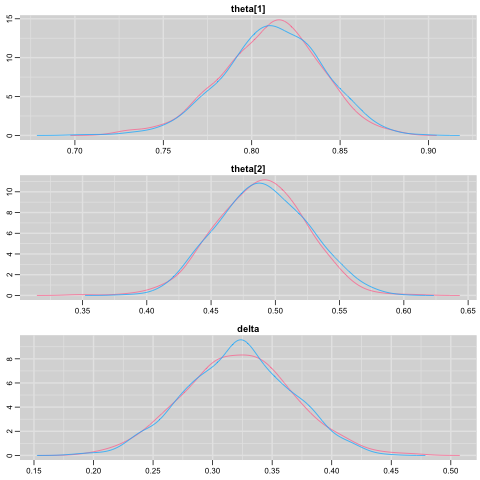

In [90]:
denplot(fit, parms = c("theta", "delta"))

In [96]:
samples <- fit$BUGSoutput$sims.list
theta <- as.data.frame(samples$theta)
colnames(theta) <- c("group1", "group2")
head(theta)

     group1    group2
1 0.8152529 0.4617618
2 0.7731299 0.5450705
3 0.8106081 0.5119701
4 0.8074178 0.5177685
5 0.8245311 0.4210163
6 0.7893670 0.4643093

### Plot posterior $\theta$ estimates

In [97]:
theta <- theta %>% gather(group, theta, one_of(c("group1", "group2")))

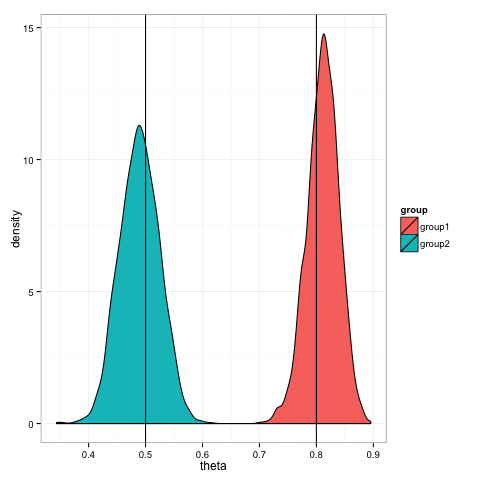

In [110]:
theta_post <- ggplot(theta, aes(x = theta,
                                fill = group)) + theme_bw()
theta_post + geom_density() +
             geom_vline(xintercept = group1_ability) +
             geom_vline(xintercept = group2_ability)

### Plot posterior $\delta$ estimates

In [120]:
delta <- as.data.frame(samples$delta)
colnames(delta) <- "delta"

q <- quantile(delta$delta, c(0.05, 0.975))

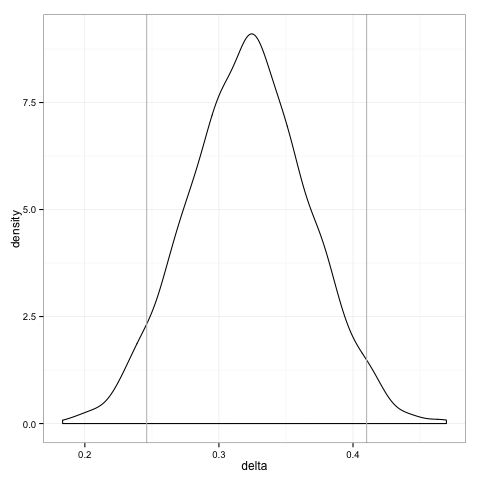

In [135]:
delta_post <- ggplot(delta, aes(x = delta)) + theme_bw()
delta_post + geom_density() +
             geom_vline(xintercept = q[1], color = "grey75") +
             geom_vline(xintercept = q[2], color = "grey75")